# Predicting Glovo's orders for Barcelona

The aim of this notebook is to show an example of how to predict Glovo's hourly orders for the next week (iteratively) using machine learning methods.

This notebook covers the next stages:
- Configuration
- Exploratory data analysis (EDA)
- Predictions
    - Naive approach
    - Feature creation
    - Radom Forest 
    - XGBoost
- Conclusions

## Configuration

In [56]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_theme(style="white", palette="pastel")

from matplotlib import pyplot as plt
import plotly.express as px

from datetime import datetime, timedelta

from statsmodels.tsa.seasonal import STL

from sklearn.model_selection import TimeSeriesSplit

In [57]:
#!pip install pmdarima
from pmdarima.arima import auto_arima

In [58]:
df = pd.read_csv('data/data_BCN.csv')
df['time'] = pd.to_datetime(df["time"])
print(df.shape)
print(df.info())
df.head()

(8766, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8766 non-null   datetime64[ns]
 1   orders  8766 non-null   float64       
 2   city    8766 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 205.6+ KB
None


,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN


In [59]:
print(df['time'].min(), df['time'].max())

2021-02-01 00:00:00 2022-02-01 23:00:00


One year of Glovo orders (hourly) starting at february 1st 2021

# EDA

Distribution of the number of orders per hour

count    5988.000000
mean      107.079259
std       120.067663
min         0.700000
25%        28.000000
50%        61.000000
75%       151.000000
max       939.000000
Name: orders, dtype: float64

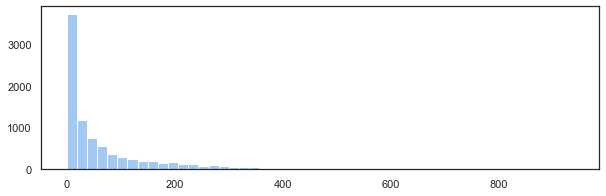

In [60]:
fig, ax = plt.subplots(figsize=(10, 3))
_ = ax.hist(df["orders"], bins=50)
df.loc[df['orders'] > 0, "orders"].describe()

Right skewed distribution: there are many hours in which the number of orders is very low and few times in which the number of orders is quite large

Time series plot of the orders

In [61]:
px.line(df.reset_index(), x="time", y="orders", title="Globo orders by hour (BCN)")

Monthly, weekly and daily trends of orders

In [62]:
df.set_index('time', inplace=True)

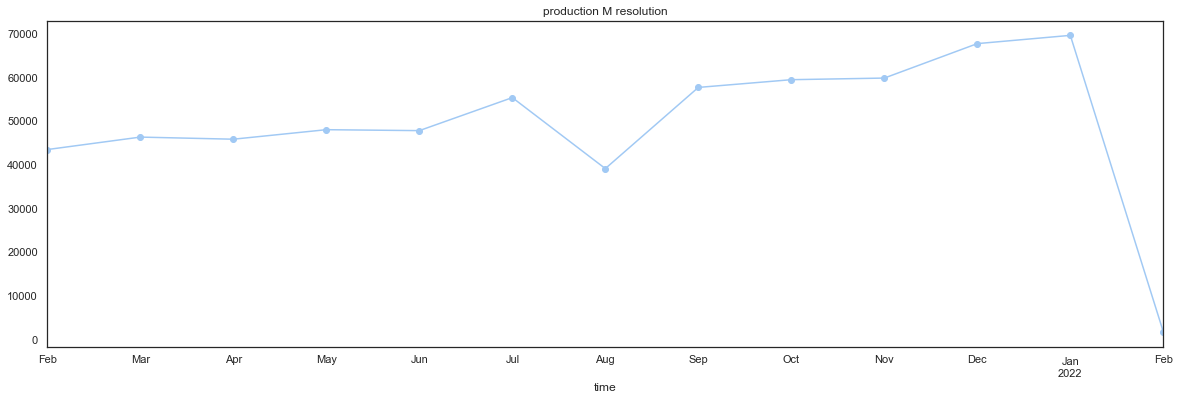

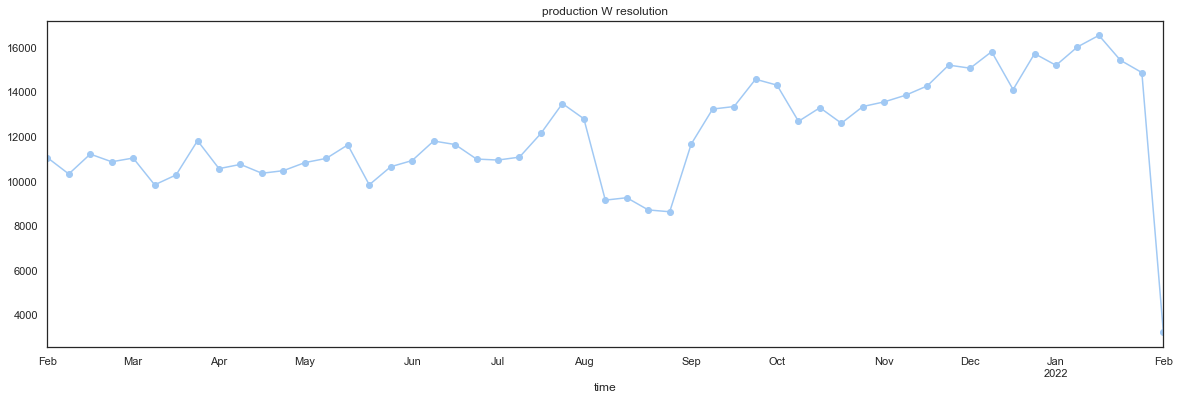

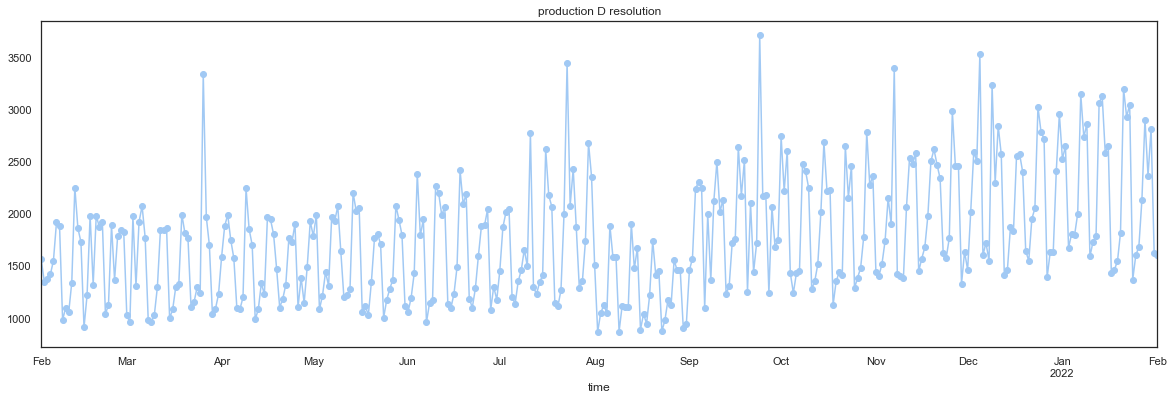

In [63]:
for resolution in ['M', 'W', 'D']:
    fig, ax = plt.subplots(figsize=(20, 6))
    df['orders'].resample(resolution).sum().plot(ax=ax, marker='o')
    ax.set_title(f'production {resolution} resolution')

We can see that on the period of the data, the orders tend to increase slightly. There is a clearly decrease in the orders duing August (holiday period).

The graph above also let us know the attypical demand of orders on three specific dates: March 26, July 23 and September 24.

In [64]:
df.loc[df['orders']>800]

,orders,city
time,,
2021-03-26 21:00:00,846.0,BCN
2021-07-23 21:00:00,873.0,BCN
2021-09-24 21:00:00,939.0,BCN


Other important dates

In [65]:
df_d = df['orders'].resample('D').sum().to_frame().reset_index()
px.line(df_d, x="time", y="orders", title="Globo orders by day (BCN)")

November 7 and December 5 were other days on which the orders show an atypical behaviour.

Orders by day of the weak and hour of the day

In [66]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

px.box(df, x="hour", y="orders", title = 'Orders by hour of the day')

In [67]:
px.box(df, x="weekday", y="orders", title = 'Orders by day of the week')

Midday hours and night (20 to 22 hours) are the most popular hours for orders. On the other hand, Friday is the day in which people order more on Glovo.

Graph of orders per hour of the day and day of the week.

In [68]:
# Data for the het map
df_ = df.copy()
df_['Week Day'] = df.index.day_name()

df_tab = df_.groupby(['Week Day', 'hour'])['orders'].mean().reset_index()
df_tab = df_tab.pivot(index='Week Day', columns='hour')
df_tab.columns = [hour for hour in range(24)]

<AxesSubplot:ylabel='Week Day'>

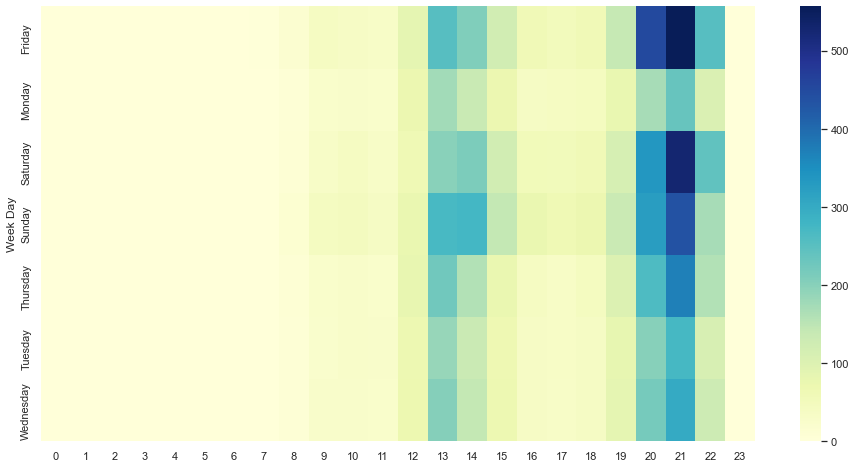

In [69]:
# Heat map
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_tab, cmap="YlGnBu")

Friday and Saturday at 9 p.m are the peaked times for orders during the week

Lets see now by month there are changes in the day and hour at which customers order 

<AxesSubplot:ylabel='Month'>

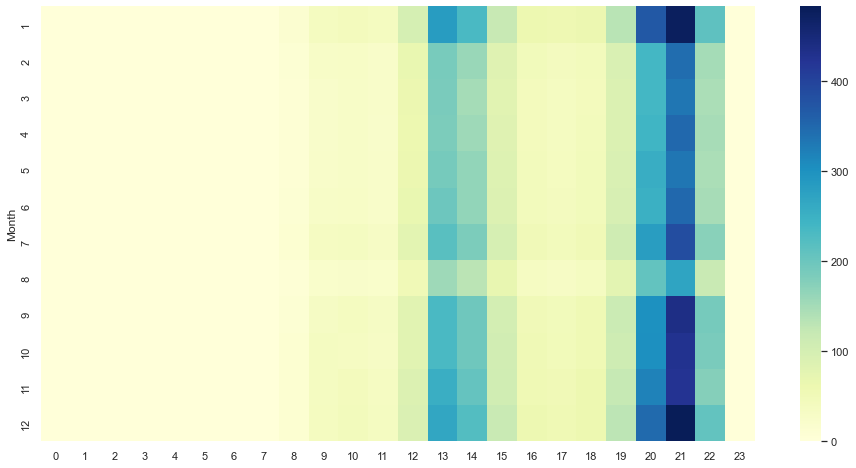

In [70]:
df_['Month'] = df.index.month

df_tab = df_.groupby(['Month', 'hour'])['orders'].mean().reset_index()
df_tab = df_tab.pivot(index='Month', columns='hour')
df_tab.columns = [hour for hour in range(24)]

# Heat map
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_tab, cmap="YlGnBu")

As seen before August in the month in which people order less on Glovo. The number of orders increases in December and January at the 20 hours

<AxesSubplot:xlabel='None-Week Day', ylabel='Month'>

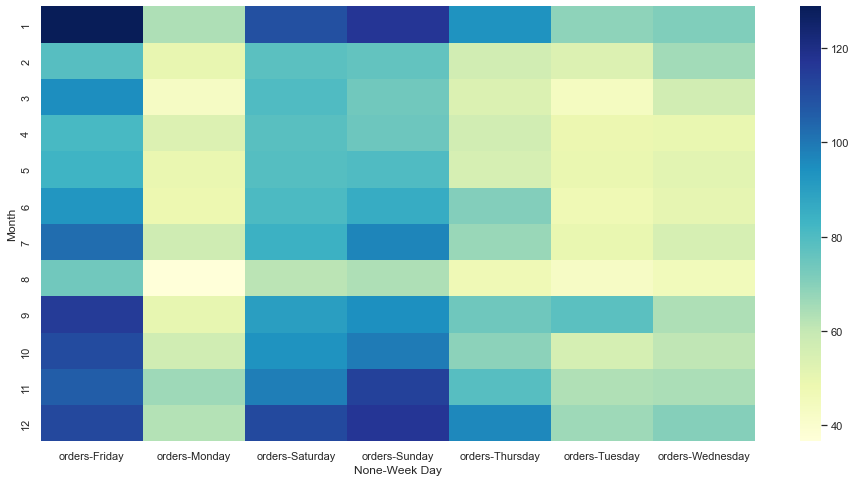

In [71]:
df_['Month'] = df.index.month

df_tab = df_.groupby(['Month', 'Week Day'])['orders'].mean().reset_index()
df_tab = df_tab.pivot(index='Month', columns='Week Day')

# Heat map
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df_tab, cmap="YlGnBu")

It is interesting to se that on November, December and January there is a high demand for orders on Sundays. On thos month the number of orders on monday is also higher in comparison with other months

Since we need to predict by week (next week) we create a id variable for the week

In [72]:
# Creation a id of week (0 for the first week in the data, 1 for the next and so on)
df = df.copy()
df['week_id'] = df.index.isocalendar().week 
df['week_id'] = np.where((df.index.year == 2022) & (df['week_id'] < 52), df['week_id'] + 52, df['week_id']) - 5
print(df['week_id'].min(), df['week_id'].max())

0 52


In [73]:
# Last week is incomplete only has data for Monday and Tuesday
df = df[(df['week_id'] != 52)]

In [74]:
# Three weeks with less values (no data on monday between 0 and 5 hours): 
# easy to impute since always there are 0 orders at those hours
missing_data = []
for week in [2, 18, 37]:
    for hour in range(6):
        date = df[(df['week_id'] == week) & (df['weekday'] == 0)].index.max()
        missing_data.append( {'time': date + timedelta(hours = hour + 1),
                              'orders': 0,
                              'city': 'BCN',
                              'hour': hour,
                              'weekday': 0,
                              'week_id': week}
                           )

anex = pd.DataFrame(missing_data).set_index('time')

# Append and sort by date
df = pd.concat([df, anex]).sort_index()

So far we have discovered that:

- The number of orders follows a right skewed distribution
- Trends observed:
    - Overall the number of orders tends to increase with the time (app usage growth)
    - On the week the number of orders increases with as the week ends
    
- The seasonalities observed are: 
    - During the period of holidays there are less orders
    - Fridays and Saturdays at 9 pm the orders the peaked
    - Orders tend to increase on the days around Friday
    
- A typical day of Glovo orders is: no orders until 6 am, then the orders increase slighly until midday when we see the firs peak, then during the afternoon hours there are few orders and from 7 pm the orders start to increase reaching a maximun at 9 pm.

- The atypical points we observed are March 26, July 23 and September 24


# Modelling

Metrics to measure the prediction power of the models:

In [20]:
from sklearn.metrics import mean_squared_error as MSE

# Function to compute the Mean Absolute Percentage Error MAPE
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# Function to compute the Symmetric mean absolute percentage error SMAPE
def SMAPE(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

## Naive base line model

Given that every Sunday at night we will predict the orders of the coming week, a naive but still logic way to predict is to use the observed values of week that is finishing. Lets do this a check the performance of this approach.

In [124]:
df_naive = df.copy()
df_naive.reset_index(inplace=True)

In [125]:
def ObservedLastWeek(X_train, X_test, y_train):
    predictions = []
    for row in X_test.index:
        day = X_test['weekday'][row]
        hour = X_test['hour'][row]
        week = X_test['week_id'][row]

        # The predicted values are those at the same weekday and hour in the previous week
        idx_ = X_train[(X_train['weekday'] == day) & (X_train['hour'] == hour) & (X_train['week_id'] == week - 1)].index
        predicted_point  = [i for i in y_train.iloc[idx_]][0]

        predictions.append(predicted_point)
    
    return predictions

In [126]:
# Cross validation of this naive approach over ten time series splits

ts_splits = TimeSeriesSplit(n_splits = 10, test_size = 24*7) # ten splits where each test set has the 168 hours of the week

target = 'orders'

results = []
iter_ = 0
for train_idx, val_idx in ts_splits.split(df_naive):
    X_train, y_train, = df_naive.iloc[train_idx].drop(target, axis=1), df_naive.iloc[train_idx][target]
    X_val, y_val, = df_naive.iloc[val_idx].drop(target, axis=1), df_naive.iloc[val_idx][target]
    
    pred = ObservedLastWeek(X_train, X_val, y_train)
    
    iter_ += 1
    results.append({'iter': iter_,
                    'MSE' : MSE(y_val, pred),
                    'SMAPE': SMAPE(y_val, pred),
                    'MAPE': MAPE(y_val, pred)})
    
results = pd.DataFrame(results)
print('Average MSE:', results['MSE'].mean(), 'Standard deviation MSE:', results['MSE'].std())
print('Average SMAPE:', results['SMAPE'].mean(), 'Standard deviation SMAPE:', results['SMAPE'].std())


Average MSE: 1578.1630952380951 Standard deviation MSE: 584.8252539705522
Average SMAPE: 30.272287114682722 Standard deviation SMAPE: 6.483793347515558


In [42]:
# Plot of the predicted values
predictions = []
for week in range(1,52):
    next_week = df_naive[df_naive['week_id'] == week + 1] # week to predict
    actual_previous = df_naive[df_naive['week_id'] <= week] # Weeks to use as training
    
    pred = ObservedLastWeek(actual_previous, next_week, actual_previous[target])
    predictions.append(pred)

predictions = [item for sublist in predictions for item in sublist]

df_naive_pred = df_naive[df_naive['week_id']>1].copy()
df_naive_pred['predictions'] = predictions

<AxesSubplot:xlabel='time', ylabel='orders'>

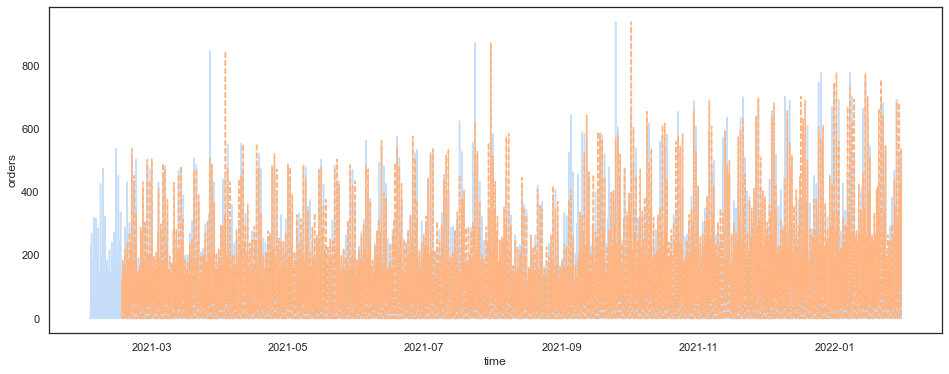

In [43]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data = df_naive, x = 'time', y = 'orders', alpha = 0.6)
sns.lineplot(data = df_naive_pred, x = 'time', y = 'predictions', linestyle='--')

## Feature creation for other ML models

In [22]:
from datetime import date

In [107]:
df['date'] = df.index.date
df_m = df.copy()

In [109]:
df_m.reset_index(inplace=True)

In [110]:
# Date time variables 
df_m['quarter'] = df_m['time'].dt.quarter
df_m['month'] = df_m['time'].dt.month
df_m['dayofyear'] = df_m['time'].dt.dayofyear
df_m['dayofmonth'] = df_m['time'].dt.day
df_m['weekofyear'] = df_m['time'].dt.weekofyear

In [111]:
# Week day hour
df_m["weekday_hour"] = (
    df_m['time'].dt.weekday.astype(str)
    + "_"
    + df_m['time'].dt.hour.astype(str)
)
df_m["weekday_hour"] = (
    df_m["weekday_hour"].astype("category").cat.codes
)

In [112]:
# Value observed in the last week
df_m["weekly_lag_1"] = (
    df_m.set_index("weekday_hour")
    .groupby("weekday_hour")["orders"]
    .shift()
    .reset_index(drop=True)
)

In [113]:
# Rolling mean
df_m["weekly_rolling_mean_4"] = (
    df_m
    .groupby("weekday_hour")["weekly_lag_1"]
    .rolling(window=4)
    .mean()
    .reset_index(level=0, drop=True)
)

In [114]:
df_m.drop(['city', 'date'], axis=1, inplace=True)
df_m.set_index('time', inplace=True)
df_m['week_id'] = df_m['week_id'].astype(int)

df_m.fillna(0, inplace=True)

df_m.head()

,orders,hour,weekday,week_id,quarter,month,dayofyear,dayofmonth,weekofyear,weekday_hour,weekly_lag_1,weekly_rolling_mean_4
time,,,,,,,,,,,,
2021-02-01 00:00:00,0.0,0,0,0,1,2,32,1,5,0,0.0,0.0
2021-02-01 01:00:00,0.0,1,0,0,1,2,32,1,5,1,0.0,0.0
2021-02-01 02:00:00,0.0,2,0,0,1,2,32,1,5,12,0.0,0.0
2021-02-01 03:00:00,0.0,3,0,0,1,2,32,1,5,17,0.0,0.0
2021-02-01 04:00:00,0.0,4,0,0,1,2,32,1,5,18,0.0,0.0


##  Random forest

In [115]:
from sklearn.ensemble import RandomForestRegressor

In [116]:
# Function for times series cross validation

def cross_val_ts(df, model, target):
    ts_splits = TimeSeriesSplit(n_splits = 10, test_size = 168) # ten splits where each test set has the 168 hours of the week

    results = []
    iter_ = 0
    
    
    for train_idx, val_idx in ts_splits.split(df):
        X_train, y_train, = df.iloc[train_idx].drop(target, axis=1), df.iloc[train_idx][target]
        X_val, y_val, = df.iloc[val_idx].drop(target, axis=1), df.iloc[val_idx][target]

        model.fit(X_train, y_train)
        
        pred = model.predict(X_val)

        iter_ += 1
        results.append({'iter': iter_,
                        'MSE' : MSE(y_val, pred),
                        'SMAPE': SMAPE(y_val, pred)})

    results =  pd.DataFrame(results)
    print('Average MSE:', results['MSE'].mean(), 'Standard deviation MSE:', results['MSE'].std())
    print('Average SMAPE:', results['SMAPE'].mean(), 'Standard deviation SMAPE:', results['SMAPE'].std(), '\n')
   

    

In [117]:
cross_val_ts(df_m, RandomForestRegressor(random_state = 123), 'orders')

Average MSE: 1219.3638758482143 Standard deviation MSE: 424.010838959031
Average SMAPE: 35.91796899858091 Standard deviation SMAPE: 6.553252475543658 



In [118]:
# Plot of the predicted values using the best parameters from the grid search
predictions = []
for week in range(10,51):
    next_week = df_m[df_m['week_id'] == week + 1] # week to predict
    actual_previous = df_m[df_m['week_id'] <= week] # Weeks to use as training
    
    rf = RandomForestRegressor(random_state = 123)
    rf.fit(actual_previous.drop(['orders'],axis=1), actual_previous['orders'])
    pred = rf.predict(next_week.drop(['orders'], axis=1)) # Forecast the next 168 hours
    predictions.append(pred)

predictions = [item for sublist in predictions for item in sublist]

df_m_pred = df_m[df_m['week_id'] > 10].copy()
df_m_pred['predictions'] = predictions

<AxesSubplot:xlabel='time', ylabel='orders'>

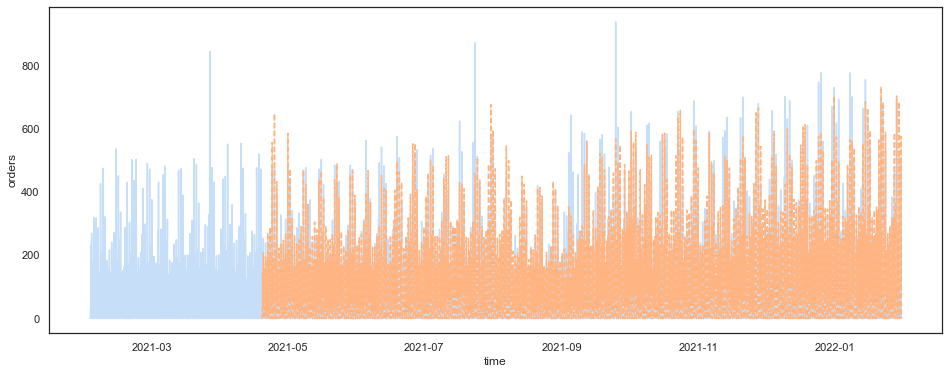

In [119]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data = df_m.reset_index(), x = 'time', y = 'orders', alpha = 0.6)
sns.lineplot(data = df_m_pred.reset_index(), x = 'time', y = 'predictions', linestyle='--')

In this case, the Random Forest is a better model when taking into account the MSE. However the naive approach is better in the SMAPE metric

##  XGboost

In [120]:
from xgboost import XGBRegressor

In [121]:
cross_val_ts(df_m, XGBRegressor(random_seed = 123), 'orders')

Average MSE: 1255.5000686263206 Standard deviation MSE: 560.8899301181244
Average SMAPE: 84.03491568123664 Standard deviation SMAPE: 6.609418997101463 



In [122]:
# Plot of the predicted values using the best parameters from the grid search
predictions = []
for week in range(10,51):
    next_week = df_m[df_m['week_id'] == week + 1] # week to predict
    actual_previous = df_m[df_m['week_id'] <= week] # Weeks to use as training
    
    rf =  XGBRegressor(max_depth = 5, 
                          learning_rate = 0.1,
                          random_seed = 123)
    rf.fit(actual_previous.drop(['orders'],axis=1), actual_previous['orders'])
    pred = rf.predict(next_week.drop(['orders'], axis=1)) # Forecast the next 168 hours
    predictions.append(pred)

predictions = [item for sublist in predictions for item in sublist]

df_m_pred = df_m[df_m['week_id'] > 10].copy()
df_m_pred['predictions'] = predictions

<AxesSubplot:xlabel='time', ylabel='orders'>

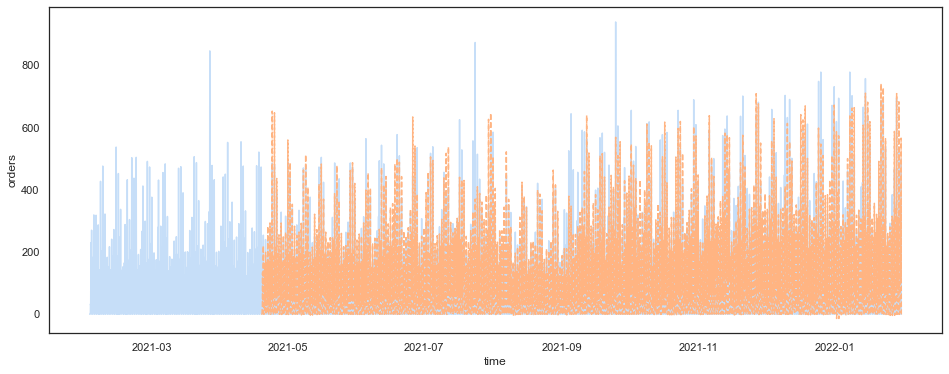

In [123]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data = df_m.reset_index(), x = 'time', y = 'orders', alpha = 0.6)
sns.lineplot(data = df_m_pred.reset_index(), x = 'time', y = 'predictions', linestyle='--')

## Conclusions

The naive approach of forecasting in which the predictions of next week's orders are the values in the last week, on average has a lower relative error (SMAPE) than more sophisticated methods such as the Random forest and the XGboost tested.

In the mean square error (MSE), the  random forest outperforms the naive method and the XGBoost.

Features that take into account the holidays were created, however, these variables did not improve the model given that this data is not real data of Glovo and in the creation of the data the effect of holidays was not taken into account.